In [1]:
%load_ext autoreload
%autoreload 2

import os, glob
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint

import matplotlib as mpl
mpl.rc('image', cmap='inferno')

import models.model_2d as mod
import forward_model as fm
import utils as ut

# for resizing PSFs as appropriate:
#import cv2

In [2]:
!gpustat

/bin/bash: /home/dshteinbok/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: gpustat: command not found


In [3]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

os.environ["CUDA_VISIBLE_DEVICES"]="0" 

# Training code for 2D spatially-varying deconvolutions

In [4]:
# declare all the variables that control how the model is set up and trained.
# Point to the training data:
target_dir = '/home/dshteinbok/TrainingData/Ground_truth_downsampled/'  # path to objects (ground truth)
input_dir = '/home/dshteinbok/TrainingData/Simulated_Miniscope_2D_Training_data/'    # path to simulated measurements (inputs to deconv.)

# PSF load type: could be "matlab"
#psf_loadtype = "matlab"
psf_loadtype = "csv"

# PSF locations, if psf_loadtype=="matlab"
filter_init_path = '../data/multiWienerPSFStack_40z_aligned.mat' # initialize with 9 PSFs
filter_key = 'multiWienerPSFStack_40z'  # key to load in

# PSF directory, if psf_loadtype=="csv"
psfs_path = '/home/dshteinbok/nV3_PSFs'

# Pixel size of the images we're dealing with. This must be the same as the desired PSF size. 
# Program will adjust size of PSFs by linear interpolation as needed, but will only crop images.
# img_dims is (width, height)
img_dims = (648, 486)
#img_dims = (486, 486)

# choose network type to train
model_type='multiwiener' # choices are 'multiwiener', 'wiener', 'unet'

# IMPORTANT! CHANGE WHEN NEEDED!
# where to store weights and training info
training_location = "saved_models/multiwiener2/model_weights"
epochlog_location = "saved_models/multiwiener2/epoch.log"

## Make dataset and dataloader for training data

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
batch_size = 2

In [6]:
target_path = sorted(glob.glob(target_dir + '*'))
input_path = sorted(glob.glob(input_dir + '*'))

image_count=len(os.listdir(target_dir))
print(image_count) 

22126


In [7]:
input_path

['/home/dshteinbok/TrainingData/Simulated_Miniscope_2D_Training_data/0.png',
 '/home/dshteinbok/TrainingData/Simulated_Miniscope_2D_Training_data/1.png',
 '/home/dshteinbok/TrainingData/Simulated_Miniscope_2D_Training_data/10.png',
 '/home/dshteinbok/TrainingData/Simulated_Miniscope_2D_Training_data/100.png',
 '/home/dshteinbok/TrainingData/Simulated_Miniscope_2D_Training_data/1000.png',
 '/home/dshteinbok/TrainingData/Simulated_Miniscope_2D_Training_data/10000.png',
 '/home/dshteinbok/TrainingData/Simulated_Miniscope_2D_Training_data/10001.png',
 '/home/dshteinbok/TrainingData/Simulated_Miniscope_2D_Training_data/10002.png',
 '/home/dshteinbok/TrainingData/Simulated_Miniscope_2D_Training_data/10003.png',
 '/home/dshteinbok/TrainingData/Simulated_Miniscope_2D_Training_data/10004.png',
 '/home/dshteinbok/TrainingData/Simulated_Miniscope_2D_Training_data/10005.png',
 '/home/dshteinbok/TrainingData/Simulated_Miniscope_2D_Training_data/10006.png',
 '/home/dshteinbok/TrainingData/Simulated_

In [8]:
# Create a first dataset of file paths and labels
dataset = tf.data.Dataset.from_tensor_slices((input_path, target_path))
dataset = dataset.shuffle(image_count, reshuffle_each_iteration=False)


# Split into train/validation
val_size = int(image_count * 0.25)

# took a small number of samples for test training to make epochs go faster
train_ds = dataset.skip(val_size)
#train_ds = dataset.skip(val_size).take(100)
#train_ds = dataset.take(100)

val_ds = dataset.take(val_size)

print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

train_ds = train_ds.map(ut.parse_function, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(ut.parse_function, num_parallel_calls=AUTOTUNE)

train_ds = ut.configure_for_performance(train_ds,batch_size)
val_ds = ut.configure_for_performance(val_ds,batch_size)

print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

16595
5531
8298
2766


(486, 648)


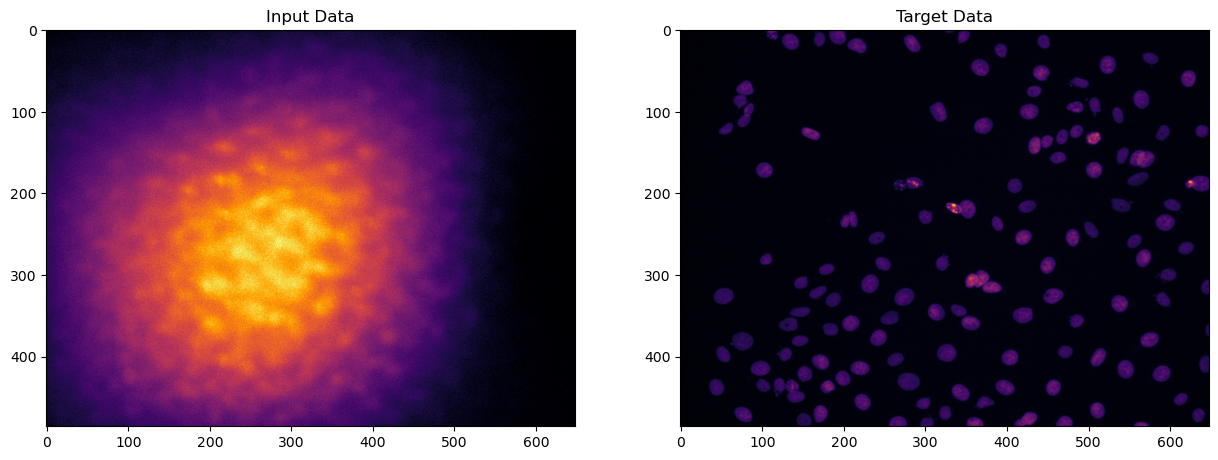

In [9]:
#visualzie data to make sure all is good
input_batch, target_batch = next(iter(val_ds))
f, ax = plt.subplots(1, 2, figsize=(15,15))

ax[0].imshow(input_batch[0,:,:,0], vmax = 1)
ax[0].set_title('Input Data')

ax[1].imshow(target_batch[0,:,:,0], vmax = 1)
ax[1].set_title('Target Data')

print(input_batch[0,:,:,0].shape)

# load in Psfs and initialize network to train

Here we initialize with 9 PSFs taken from different parts in the field of view

In [10]:
# load the PSFs
if psf_loadtype == "matlab":
    registered_psfs_path = filter_init_path
    psfs = scipy.io.loadmat(registered_psfs_path)
    psfs=psfs[filter_key]
elif psf_loadtype == "csv":
    # expect a directory with a bunch of PSFs therein as separate csvs;
    # list out all csv file names in the directory
    psf_paths = glob.glob(psfs_path.removesuffix('/') + '/*')
    # iterate through that list,
    # open and append each to the psfs array,
    psfs = [[]]
    for path in psf_paths:
        psfs[0].append(np.loadtxt(path, delimiter=',', encoding='utf-8-sig'))
    # convert the psfs array to an np.ndarray
    psfs = np.transpose(np.asarray(psfs), (2,3,1,0))
else:
    raise ValueError("Not sure how to load PSFs")
psfs.shape

# for testing, cut the psf and look at padding behaviour
#psfs = psfs[162:324, 216:432, :, :]
#psfs.shape
# Test result: it works!!!

(32, 32, 2, 1)

In [11]:
if model_type=='unet':
    model =mod.UNet(486, 648, 
                             encoding_cs=[24, 64, 128, 256, 512, 1024],
                             center_cs=1024,
                             decoding_cs=[512, 256, 128, 64, 24, 24],
                             skip_connections=[True, True, True, True, True, False])
elif model_type=='wiener':

    registered_psfs_path = filter_init_path
    psfs = scipy.io.loadmat(registered_psfs_path)
    psfs=psfs[filter_key]
    psfs=psfs[:,:,0,0]
    psfs=psfs/np.max(psfs)
    
    Ks=1

    model = mod.UNet_wiener(486, 648, psfs, Ks, 
                             encoding_cs=[24, 64, 128, 256, 512, 1024],
                             center_cs=1024,
                             decoding_cs=[512, 256, 128, 64, 24, 24],
                             skip_connections=[True, True, True, True, True, False])
    
    print(psfs.shape, 1)
    
elif model_type=='multiwiener':
    psfs=psfs[:,:,:,0]
    print(psfs.shape)
    #psfs = cv2.resize(psfs, img_dims)
    # rather than resizing, zero-pad to appropriate size
    # this means that original PSF can be any size, but Image Delta must be set correctly
    
    print(psfs.shape)
    psfs=psfs/np.max(psfs)
    
    Ks =np.ones((1,1,psfs.shape[2]))
    
    model =mod.UNet_multiwiener_resize(img_dims[1], img_dims[0], psfs, Ks, 
                         encoding_cs=[24, 64, 128, 256, 512, 1024],
                         center_cs=1024,
                         decoding_cs=[512, 256, 128, 64, 24, 24],
                         skip_connections=[True, True, True, True, True, False])
    
    print('initialized filter shape:', psfs.shape, 'initialized K shape:', Ks.shape)

(32, 32, 2)
(32, 32, 2)
initialized filter shape: (32, 32, 2) initialized K shape: (1, 1, 2)


In [12]:
model.build((None, img_dims[1], img_dims[0], 1))

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 486, 648, 1  0           []                               
                                )]                                                                
                                                                                                  
 multi_wiener_deconvolution (Mu  (None, 486, 648, 2)  629858     ['input_1[0][0]']                
 ltiWienerDeconvolution)                                                                          
                                                                                                  
 conv2d (Conv2D)                (None, 486, 648, 24  432         ['multi_wiener_deconvolution[0][0
                                )                                ]']                          

                                                                                                  
 activation_7 (Activation)      (None, 60, 81, 256)  0           ['batch_normalization_7[0][0]']  
                                                                                                  
 average_pooling2d_3 (AveragePo  (None, 30, 40, 256)  0          ['activation_7[0][0]']           
 oling2D)                                                                                         
                                                                                                  
 conv2d_8 (Conv2D)              (None, 30, 40, 512)  1179648     ['average_pooling2d_3[0][0]']    
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 30, 40, 512)  2048       ['conv2d_8[0][0]']               
 rmalization)                                                                                     
          

 conv2d_16 (Conv2D)             (None, 30, 40, 256)  2359296     ['concatenate_1[0][0]']          
                                                                                                  
 batch_normalization_16 (BatchN  (None, 30, 40, 256)  1024       ['conv2d_16[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_16 (Activation)     (None, 30, 40, 256)  0           ['batch_normalization_16[0][0]'] 
                                                                                                  
 conv2d_17 (Conv2D)             (None, 30, 40, 256)  589824      ['activation_16[0][0]']          
                                                                                                  
 batch_normalization_17 (BatchN  (None, 30, 40, 256)  1024       ['conv2d_17[0][0]']              
 ormalizat

 concatenate_4 (Concatenate)    (None, 243, 324, 12  0           ['tf.image.resize_4[0][0]',      
                                8)                                'activation_3[0][0]']           
                                                                                                  
 conv2d_25 (Conv2D)             (None, 243, 324, 24  27648       ['concatenate_4[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_25 (BatchN  (None, 243, 324, 24  96         ['conv2d_25[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 activation_25 (Activation)     (None, 243, 324, 24  0           ['batch_normalization_25[0][0]'] 
          

In [13]:
#tf.config.list_physical_devices()

# Train

In [14]:
# ADDED BY DANIEL:
# Prepare EpochLogger and load weights, if necessary, into the model
import epochlog.epochlog as el
epochlogger = el.EpochLogger(model, epochlog_location, training_location)
epochlogger.load_weights()
print("done all the crap")

## Training with TF.Dataset
initial_learning_rate = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False) #1e-3 diverges

# what's the expected input shape for the model?
exp_shape = model.get_config()["layers"][0]["config"]["batch_input_shape"]
print(exp_shape)

# Keep results for plotting
train_loss_results = []
train_accuracy_results = []
validtate_loss_results=[]
num_epochs = 100
loss_func=ut.SSIMLoss_l1
learning_rate_counter=0
#for epoch in range(num_epochs):
starting_epoch = epochlogger.epochs_done()
print("Starting on epoch number: " + str(starting_epoch))
for epoch in range(starting_epoch, num_epochs):
    validation_loss_avg=tf.keras.metrics.Mean()
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.MeanSquaredError()

    # Training loop
    iter_num=0
    for x, y in train_ds:
        # Optimize the model
        #print("x shape: " + str(x.shape))
        #print("y shape: " + str(y.shape))
        # NOTICE: x.shape = y.shape = (2, 486, 648, 1)
        # TODO: resize x and y based on expected dimensions for the model
        # Crop to the top left corner of the image to make it fit our size if it is too large
        if x.shape[1] > exp_shape[1]:
            x = x[:,:exp_shape[1],:,:]
        if x.shape[2] > exp_shape[2]:
            x = x[:,:,:exp_shape[2],:]
        if y.shape[1] > exp_shape[1]:
            y = y[:,:exp_shape[1],:,:]
        if y.shape[2] > exp_shape[2]:
            y = y[:,:,:exp_shape[2],:]
        loss_value, grads = ut.grad(model,loss_func, x, y)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Track progress
        epoch_loss_avg.update_state(loss_value)  # Add current batch loss

        epoch_accuracy.update_state(y, model(x)) 
        # Print every 1
        if iter_num % 1 == 0:
            print("Epoch {:03d}: Step: {:03d}, Loss: {:.3f}, MSE: {:.3}".format(epoch, iter_num,epoch_loss_avg.result(),
                                                                        epoch_accuracy.result()),end='\r')
        iter_num=iter_num+1
        
    

  # End epoch
    #print("Ending Epoch")
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())


    # skip validation, since SSIM function is broken
    #for x_val, y_val in val_ds:
        #val_loss_value= loss_func(model, x_val, y_val)
        #validation_loss_avg.update_state(val_loss_value)
        
        
    validtate_loss_results.append(validation_loss_avg.result())    
    #if epoch % 1 == 0:
        #print("Epoch {:03d}: MSE: {:.3}, Training Loss: {:.3f}, Validation Loss: {:.3f}".format(epoch,
        #                                                            epoch_accuracy.result(), epoch_loss_avg.result(), 
        #                                                                                        validation_loss_avg.result()))
    epochlogger.done_epoch()

done all the crap
(None, 486, 648, 1)
Starting on epoch number: 0


KeyboardInterrupt: 

In [ ]:
# model.load_weights('./saved_models/multiwiener')

In [ ]:
# test on validation data
input_batch, target_batch = next(iter(val_ds))
imnum=1
f, ax = plt.subplots(1, 2, figsize=(15,15))
ax[0].imshow((target_batch[imnum,:,:,0]))
ax[0].set_title('Target Data')

test=model(input_batch[imnum,:,:,0].numpy().reshape((1,486, 648,1)))
ax[1].set_title('recon')
ax[1].imshow(test[0,:,:])


Once training is working, save your model using: 

    model.save_weights('./saved_models/model_name')

You can save after training is complete, or periodically throughout epochs.

In [ ]:
# show the first PSF as an example of what we're looking for
plt.imshow(psfs[:,:,0])